In [80]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2
import copy

from tqdm import tqdm
import glob

In [81]:
class Image():
    
    def __init__(self, image, landmarks, name):
        # self.image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        self.image = image
        self.original_image = copy.deepcopy(self.image)
        self.landmarks = landmarks
        self.name = name
        self.neutralised_image = np.array([])
        self.hash = hash(self)
    
    def setNeutralisedImage(self, image):
        self.neutralised_image = image
        
    def getNeutralisedImage(self):
        return self.neutralised_image
        
    def getName(self):
        return self.name
        
    def getImage(self):
        return self.image
    
    def clearImage(self):
        self.image= copy.deepcopy(self.original_image)
        return self.image
    
    def getLandmarks(self):
        return self.landmarks
    
    def getHash(self):
        return self.hash

In [82]:
def getLandmarksForImage(imagePath):
    cur_landmark = "/".join(str(imagePath).rsplit('/',3)[-3:])[:-4]
    landmark_path = ck_landmarks_path + '/' + cur_landmark + '_landmarks.txt'
    landmarks = np.loadtxt(landmark_path)
    return landmarks


def view_landmarks(landmarks, color='r'):
    xs, ys = list(zip(*landmarks))
    plt.scatter(xs, ys, color=color)
    return 

In [83]:
base_path = "../Data/"

In [84]:
ck_data_path = base_path + 'CK_CK+/CK+/cohn-kanade-images'
ck_landmarks_path = base_path + 'CK_CK+/CK+/Landmarks'
ck_image_files = glob.glob(ck_data_path+'/**/*.png', recursive=True)

ck_image_files = ck_image_files[7000:]

In [85]:
len(ck_image_files)

3708

In [86]:
face_det = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
face_det2 = cv2.CascadeClassifier(cv2.data.haarcascades +"haarcascade_frontalface_alt2.xml")
face_det3 = cv2.CascadeClassifier(cv2.data.haarcascades +"haarcascade_frontalface_alt.xml")
face_det4 = cv2.CascadeClassifier(cv2.data.haarcascades +"haarcascade_frontalface_alt_tree.xml")

def detect_face(f, ld):
    ''' function to detect face, crop the image and resize it and resize the corresponding landmarks too '''
    frame = cv2.imread(f) #Open image
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #Convert image to grayscale
    face = face_det.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face2 = face_det2.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face3 = face_det3.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face4 = face_det4.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
#     ld = np.array([np.array(i) for i in ld])
    crop_ld = ld
    #Go over detected faces, stop at first detected face, return empty if no face.
    if len(face) == 1:
        facefeatures = face
    elif len(face2) == 1:
        facefeatures = face2
    elif len(face3) == 1:
        facefeatures = face3
    elif len(face4) == 1:
        facefeatures = face4
    else:
        facefeatures = ""
    for (x, y, w, h) in facefeatures:
        fw, fh = w, h
        if any(ld[:,0] > x+w):
            fw = int(max(ld[:,0]-x))
        if any(ld[:,1] > y+h):
            fh = int(max(ld[:,1]-y))
#         gray = gray[y:y+h, x:x+w] #Cut the frame to size
        gray = gray[y:y+fh+5, x:x+fw+5] #Cut the frame to size to max of landmark with padding of 5px
        ld_rescale_factor = (gray.shape[1]/crop_imsize, (gray.shape[0]/crop_imsize))
        crop_ld = np.array(list(zip(ld[:,0]-x, ld[:, 1]-y)))
    try:
        output = cv2.resize(gray, (crop_imsize, crop_imsize))
        crop_ld = crop_ld/ld_rescale_factor
        cv2.imwrite(crop_path+'/crop_'+f.split('/')[-1], output)
    except:
        output = gray

    return output, crop_ld

In [87]:
images = []
crop_imsize = 350

with tqdm(total=len(ck_image_files), desc="Processing entries") as pbar:
    for i, ck_image in enumerate(ck_image_files):

        landmarks = getLandmarksForImage(ck_image)
        image, landmarks = detect_face(ck_image, landmarks)
        image = cv2.resize(image,(crop_imsize, crop_imsize))
        images.append(Image(image, landmarks, ck_image))
        
        pbar.update(1)

Processing entries: 100%|██████████| 3708/3708 [11:51<00:00,  5.21it/s]


# Compute average landmark position

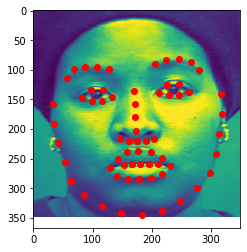

In [88]:
plt.imshow(images[1].getImage())
view_landmarks(images[1].getLandmarks())

In [89]:
numImages = len(images)

avgLandmarks = (images[0].getLandmarks() / numImages)

for image in images[1:]:
    avgLandmarks += (image.getLandmarks()) / numImages

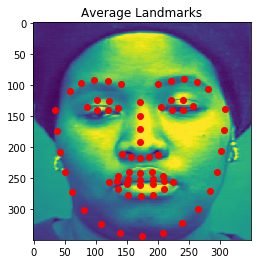

In [90]:
plt.imshow(images[0].getImage())
plt.title("Average Landmarks")
view_landmarks(avgLandmarks)

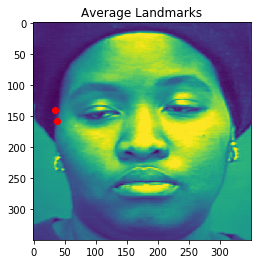

In [91]:
plt.imshow(images[0].getImage())
plt.title("Average Landmarks")
view_landmarks(avgLandmarks[:1])
view_landmarks(images[0].getLandmarks()[:1])

## Transform images to shape free variant

In [92]:
def appendLastRowAsCol(npMatrix):
    return np.c_[npMatrix[:-1,:].T, np.array([npMatrix[-1,:]]).T ]

In [93]:
def pairPlot(im1, im2, clear_figure=False, title=''):
    if not clear_figure:
        plt.figure()
    
    fig, axes = plt.subplots(1,2)
    axes[0].imshow(im1)
    axes[1].imshow(im2)

    fig.suptitle(title, fontsize=16)
    
def getTrianglePts(triangle_points_array):
    return (tuple(triangle_points_array[0:2].astype(np.int32)), tuple(triangle_points_array[2:4].astype(np.int32)), tuple(triangle_points_array[4:6].astype(np.int32)))

def getTriangleImage(im, triangle_points_array):
    pt1, pt2, pt3 = getTrianglePts(triangle_points_array)
    triangle = np.array([pt1, pt2, pt3])
    
    triangle_im = im
    triangle_mask = np.zeros_like(im)

    triangle_mask_fill_points = np.array([
            [pt1[0], pt1[1]],
            [pt2[0], pt2[1]],
            [pt3[0], pt3[1]]
        ], np.int32)
    cv2.fillConvexPoly(triangle_mask, triangle_mask_fill_points, (255,255,255))
        
    cropped_triangle = cv2.bitwise_and(triangle_mask, triangle_im)
    return cropped_triangle

def drawTriangle(im, triangle_points_array, color):
    pt1, pt2, pt3 = getTrianglePts(triangle_points_array)
    
    cv2.line(im, pt1, pt2, color, 2)
    cv2.line(im, pt1, pt3, color, 2)
    cv2.line(im, pt3, pt2, color, 2)

def draw_delaunay(im, subdiv_triangles, color):

    for t in subdiv_triangles:
        drawTriangle(im, t, color)

def get_second_delaunay_triangles(im, src_triangles, src_landmarks, dest_landmarks):
    src_landmarks = np.array(src_landmarks).astype(np.float32)

    dest_triangles = np.array([[1,2,3,4,5,6]])
    for t in src_triangles:
        pt1 = np.array([t[0], t[1]])
        pt2 = np.array([t[2], t[3]])
        pt3 = np.array([t[4], t[5]])
  
        index_pt1 = np.where((pt1 == src_landmarks).all(axis=1))[0][0]
        index_pt2 = np.where((pt2 == src_landmarks).all(axis=1))[0][0]
        index_pt3 = np.where((pt3 == src_landmarks).all(axis=1))[0][0]

        dest_triangle = np.array([dest_landmarks[index_pt1], dest_landmarks[index_pt2], dest_landmarks[index_pt3]]).flatten()
        dest_triangles = np.concatenate((dest_triangles, np.array([dest_triangle])), axis=0)
    
    return dest_triangles[1:]

In [94]:
DRAW_EXAMPLE = False

dest = list(map(lambda x: tuple(x),avgLandmarks))

with tqdm(total=len(images), desc="Neutralizing emotions") as pbar:

    for image in images[:]:
        src = list(map(lambda x: tuple(x),image.getLandmarks()))

        image.clearImage()
        im = image.getImage()
        im_shape = im.shape

        rect = (0,0,im_shape[1],im_shape[0])
        subdiv = cv2.Subdiv2D(rect)
        
        try:
            subdiv.insert(src)
        except:
            pbar.update(1)
            continue
            
        src_triangles = subdiv.getTriangleList()

        dest_triangles = get_second_delaunay_triangles(im, src_triangles, src, dest)

        warped_image = np.zeros_like(im)      
        for (src_triangle, dest_triangle) in zip(src_triangles, dest_triangles):
            ## Change this code
            src_triangle = src_triangle.reshape(3,2).astype(np.float32)
            dest_triangle = dest_triangle.reshape(3,2).astype(np.float32)

            M = cv2.getAffineTransform(src_triangle, dest_triangle)

            src_triangle_image = getTriangleImage(im, src_triangle.flatten())

            dest_boundingRect = cv2.boundingRect(dest_triangle)
            (dx, dy, dw, dh) = dest_boundingRect

            warped_image_triangle = cv2.warpAffine(src_triangle_image, M,  src_triangle_image.shape)

            warped_triangle_area = warped_image[dy: dy + dh, dx : dx + dw]        
            warped_triangle_area = cv2.add(warped_triangle_area, warped_image_triangle[dy: dy + dh, dx : dx + dw])

            warped_image[dy: dy + dh, dx : dx + dw] = warped_triangle_area

        image.setNeutralisedImage(warped_image)
        pbar.update(1)

        if DRAW_EXAMPLE:
            print("DRAW_EXAMPLE IS TRUE")
            pairPlot(warped_image,im )
            break

Neutralizing emotions: 100%|██████████| 3708/3708 [03:51<00:00, 16.02it/s]


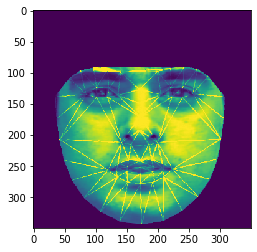

In [95]:
plt.imshow(images[257].getNeutralisedImage())

In [96]:
images[0].getName()

'../Data/CK_CK+/CK+/cohn-kanade-images/S069/001/S069_001_00000006.png'

In [97]:
import os
from PIL import Image

with tqdm(total=len(images), desc="Saving Neutralized emotions") as pbar:

    for image in images:

        path = "NeutralisedImages" + image.getName().split("Data")[-1]
        directory = "/".join(path.split("/")[:-1])

        if not os.path.exists(directory):
            os.makedirs(directory)

        try:
            im = Image.fromarray(image.getNeutralisedImage())
            im.save(path)
            pbar.update(1)
        except:
            
            pbar.update(1)
            continue


Saving Neutralized emotions: 100%|██████████| 3708/3708 [00:58<00:00, 63.58it/s]
